In [1]:
#Importamos las librerias a utilizar.
import pandas as pd
import numpy as np
import string 
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')
import re
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from nltk.tokenize import word_tokenize
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#Cargamos el dataset de entrenamiento. 
df_train=pd.read_csv("train.csv")
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#Cargamos el dataset de test. 
df_test=pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
#Cargamos el sample submission
df_sample=pd.read_csv('sample_submission.csv')
df_sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


#### Preprosesamiento de Datos

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#Vemos los valores de target
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:>

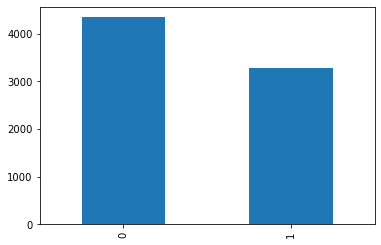

In [7]:
#Graficamos los valores de target
df_train['target'].value_counts().plot(kind='bar')

Podemos observar que la mayoria de tweets son falsos.

In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
#Vemos los valores de keyword.
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
damage                   41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [10]:
#Vemos los datos estadisticos de Keyword
df_train.groupby(['keyword']).mean()

,id,target
keyword,,
ablaze,70.388889,0.361111
accident,121.800000,0.685714
aftershock,171.323529,0.000000
airplane%20accident,220.142857,0.857143
ambulance,269.052632,0.526316
...,...,...
wounded,10609.135135,0.702703
wounds,10662.393939,0.303030
wreck,10708.513514,0.189189


In [11]:
df_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [12]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


#### Limpieza del Texto

In [13]:
EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}
URLPATTERN        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
USERPATTERN       = '@[^\s]+'
SEQPATTERN   = r"(.)\1\1+"
SEQREPLACE = r"\1\1"

In [14]:
#Quitamos los emojis, url's, signos.
def tweetsLimpios(text):
    lowercase = text.lower()
    punc_removal = [char for char in lowercase if char not in string.punctuation]
    punc_removal_joined = ''.join(punc_removal)
    url_removal = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', punc_removal_joined, flags=re.MULTILINE)
    for emoji in EMOJIS.keys():
        url_removal = url_removal.replace(emoji, "EMOJI" + EMOJIS[emoji])  

    emoji_removal=url_removal
    stopwords_removal = [word for word in emoji_removal.split() if word not in stopwords.words('english')]
    return stopwords_removal

In [15]:
df_train['textoLimpio']=df_train['text'].apply(tweetsLimpios).astype(str)

In [16]:
df_test['textoLimpio']=df_test['text'].apply(tweetsLimpios).astype(str)

In [17]:
df_train.head()

,id,keyword,location,text,target,textoLimpio
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"['deeds', 'reason', 'earthquake', 'may', 'alla..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"['forest', 'fire', 'near', 'la', 'ronge', 'sas..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"['residents', 'asked', 'shelter', 'place', 'no..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"['13000', 'people', 'receive', 'wildfires', 'e..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm..."


In [18]:
df_train_clean=df_train[['textoLimpio','target']]

In [19]:
df_train_clean.head()

,textoLimpio,target
0,"['deeds', 'reason', 'earthquake', 'may', 'alla...",1
1,"['forest', 'fire', 'near', 'la', 'ronge', 'sas...",1
2,"['residents', 'asked', 'shelter', 'place', 'no...",1
3,"['13000', 'people', 'receive', 'wildfires', 'e...",1
4,"['got', 'sent', 'photo', 'ruby', 'alaska', 'sm...",1


#### Tokenización

In [20]:
#Tokenizamos la columna de textoLimpio
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_train_clean['textoLimpio'].values)
X = tokenizer.texts_to_sequences(df_train_clean['textoLimpio'].values)
X = pad_sequences(X)

## LSTM Model 

In [21]:
#Creamos el modelo LSTM
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#Resumen del modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 18, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
#Separamos el dataset en train y test para evaluarlos en el modelo. 
Y = pd.get_dummies(df_train_clean['target']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5100, 18) (5100, 2)
(2513, 18) (2513, 2)


In [23]:
#Vemos el funcionamiento del modelo
batch_size = 16
history = model.fit(X_train, Y_train, epochs = 19, batch_size=batch_size, verbose = 2)

Epoch 1/19
319/319 - 15s - loss: 0.5340 - accuracy: 0.7314
Epoch 2/19
319/319 - 13s - loss: 0.3877 - accuracy: 0.8302
Epoch 3/19
319/319 - 13s - loss: 0.3407 - accuracy: 0.8492
Epoch 4/19
319/319 - 13s - loss: 0.2978 - accuracy: 0.8729
Epoch 5/19
319/319 - 13s - loss: 0.2539 - accuracy: 0.8927
Epoch 6/19
319/319 - 13s - loss: 0.2225 - accuracy: 0.9114
Epoch 7/19
319/319 - 12s - loss: 0.1913 - accuracy: 0.9224
Epoch 8/19
319/319 - 12s - loss: 0.1656 - accuracy: 0.9345
Epoch 9/19
319/319 - 11s - loss: 0.1464 - accuracy: 0.9408
Epoch 10/19
319/319 - 11s - loss: 0.1269 - accuracy: 0.9490
Epoch 11/19
319/319 - 11s - loss: 0.1225 - accuracy: 0.9506
Epoch 12/19
319/319 - 11s - loss: 0.1111 - accuracy: 0.9541
Epoch 13/19
319/319 - 11s - loss: 0.0988 - accuracy: 0.9610
Epoch 14/19
319/319 - 11s - loss: 0.0989 - accuracy: 0.9576
Epoch 15/19
319/319 - 11s - loss: 0.0905 - accuracy: 0.9653
Epoch 16/19
319/319 - 11s - loss: 0.0869 - accuracy: 0.9639
Epoch 17/19
319/319 - 12s - loss: 0.0810 - accura

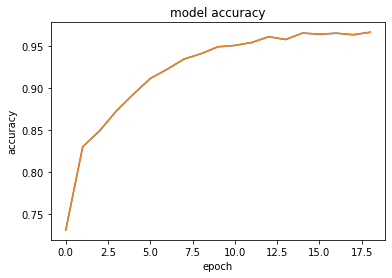

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

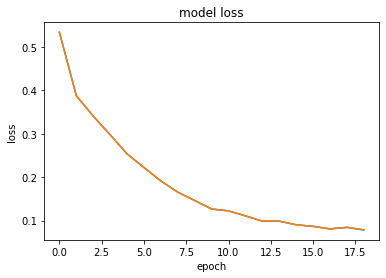

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

En estas graficas podemos obserbar como el modelo tiende a tener su accuracy exponencialmente de una manera positiva, al mismo tiempo que la perdida es menor, lo que nos brinda una buena confiabilidad en el algoritmo. 

### Predicciones con el modelo LSTM

In [26]:
df_test.head()

,id,keyword,location,text,textoLimpio
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['heard', 'earthquake', 'different', 'cities',..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['apocalypse', 'lighting', 'spokane', 'wildfir..."
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['typhoon', 'soudelor', 'kills', '28', 'china'..."


In [27]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3263 non-null   int64 
 1   keyword      3237 non-null   object
 2   location     2158 non-null   object
 3   text         3263 non-null   object
 4   textoLimpio  3263 non-null   object
dtypes: int64(1), object(4)
memory usage: 127.6+ KB


In [28]:
#Tokenizamos el textoLimpio
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_test['textoLimpio'].values)
X = tokenizer.texts_to_sequences(df_test['textoLimpio'].values)
X = pad_sequences(X)

In [29]:
#Creamos la predicción
pred=model.predict(X)

In [30]:
labels=[0,1]

In [31]:
pred.shape

(3263, 2)

In [32]:
#Vemos los valores de la predicción. 
pred

array([[1.5988037e-07, 9.9999988e-01],
       [8.5204417e-01, 1.4795589e-01],
       [9.9727196e-01, 2.7280205e-03],
       ...,
       [2.5230818e-04, 9.9974769e-01],
       [4.0419548e-07, 9.9999964e-01],
       [8.0779487e-01, 1.9220512e-01]], dtype=float32)

In [33]:
#Para guardar la prediccion
tweetPredict=[]

In [34]:
df_test.head()

,id,keyword,location,text,textoLimpio
0,0,NaN,NaN,Just happened a terrible car crash,"['happened', 'terrible', 'car', 'crash']"
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","['heard', 'earthquake', 'different', 'cities',..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","['forest', 'fire', 'spot', 'pond', 'geese', 'f..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"['apocalypse', 'lighting', 'spokane', 'wildfir..."
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"['typhoon', 'soudelor', 'kills', '28', 'china'..."


In [35]:
df_test['id'][0]

0

In [36]:
#Creamos una funcion que guarde los datos del id, target y la prediccion. 
idx=0
for p in pred:
    predict=[]
    t_id=df_test['id'][idx]
    idx+=1
    target=labels[np.argmax(p)]
    predict.append(t_id)
    predict.append(target)
    tweetPredict.append(predict)
    

In [37]:
df_sub=pd.DataFrame(tweetPredict,columns=["id","target"])

In [38]:
df_sub.head()

,id,target
0,0,1
1,2,0
2,3,0
3,9,0
4,11,1


In [39]:
len(df_sub)

3263

In [40]:
#Vemos la cantidad de 0 y 1 segun las predicciones. 
df_sub['target'].value_counts()

1    1661
0    1602
Name: target, dtype: int64

#### Visualización 

In [41]:
pie = df_sub.groupby("target").count()

<AxesSubplot:ylabel='id'>

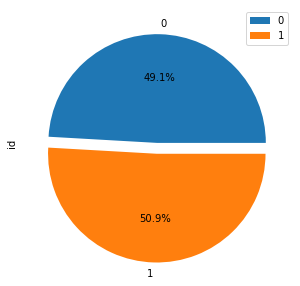

In [42]:
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

Observamos que la cantidad de tweets falsos es mayor a la de verdaderos. 

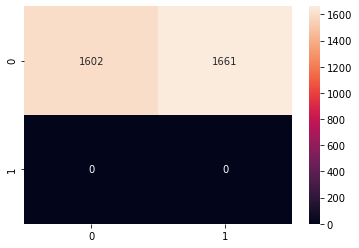

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(df_sample.target, df_sub.target)
f = sns.heatmap(cm, annot=True, fmt='d')

In [44]:
df_sub.to_csv('submission_lstm.csv',index=False)

In [45]:
def save_prediction(pred,model):
    df_test=pd.read_csv('test.csv')
    submission_list=[]
    idx=0
    tweet_predict=[]
    for p in pred:
        predict=[]
        t_id=df_test['id'][idx]
        idx+=1
        target=p
        predict.append(t_id)
        predict.append(target)
        tweet_predict.append(predict)
    df_sub=pd.DataFrame(tweet_predict,columns=['id','target'])
    df_sub.to_csv('submission_'+model+".csv",index=False)
    print(model+"- model prediction")
    print(df_sub['target'].value_counts())

# Regresión Logística + CountVectorized

In [46]:
#Creamos una nueva columna llamada kfold y la llenamos con -1
df_train["kfold"]=-1

In [47]:
df_train=df_train.sample(frac=1).reset_index(drop=True)

In [48]:
y=df_train.target

In [49]:
kf=model_selection.StratifiedKFold(n_splits=4)

In [50]:
for f,(t_,v_) in enumerate(kf.split(X=df_train,y=y)):
    df_train.loc[v_,'kfold']=f

In [51]:
#Vemos los datos. 
df_train.head()

,id,keyword,location,text,target,textoLimpio,kfold
0,4345,dust%20storm,Dutch/English/German,New Mad Max Screenshots Show Off a Lovely Dust...,0,"['new', 'mad', 'max', 'screenshots', 'show', '...",0
1,3480,derailed,"Washington DC / Nantes, France",Going to starbs it's only 70 degrees part of t...,1,"['going', 'starbs', '70', 'degrees', 'part', '...",0
2,3754,destruction,"Georgia, USA",@cinla1964 @windowgatribble The Contrasts of F...,0,"['cinla1964', 'windowgatribble', 'contrasts', ...",0
3,4297,drowning,"San Diego, California",I'm drowning in hw now and that's w/o going to...,0,"['im', 'drowning', 'hw', 'thats', 'wo', 'going...",0
4,3626,desolation,on twitter,yeah 1:57 | Lamb Of God - Rock Am Ring 2015 ...,0,"['yeah', '157', 'lamb', 'god', 'rock', 'ring',...",0


In [52]:
df_train['kfold'].value_counts()

0    1904
1    1903
2    1903
3    1903
Name: kfold, dtype: int64

In [71]:
#Creamos la funcion para nuestro modelo 
for fold_ in range(5):
    train_df=df_train[df_train.kfold!=fold_].reset_index(drop=True)
    if fold_==4:
        train_df=df_train.reset_index(drop=True)
        test_df=df_test.reset_index(drop=True)
    else:
        test_df=df_train[df_train.kfold==fold_].reset_index(drop=True)
    #Utilizamos el CountVectorizer con el word_tokenize de NLTK y la funcion se tokeniza
    count_vec=CountVectorizer(
        tokenizer=word_tokenize,
        token_pattern=None)
    #Se ajusta count_vec en la revision de los datos de entrenamiento
    count_vec.fit(train_df.text)
    #Se transforman las revisiones de los datos de entrenamiento y validación
    x_train=count_vec.transform(train_df.text)
    x_test=count_vec.transform(test_df.text)
    #Se inicia el modelo de regresion Logistica
    model_logistic=linear_model.LogisticRegression(max_iter=1000)
    f=[0, 1, 2, 3]
    acc =[0.809, 0.791, 0.799, 0.796]
    #Se ajustar el modelo a los datos de entrenamiento y a los sentimientos
    model_logistic.fit(x_train,train_df.target)
    preds_log=model_logistic.predict(x_test)
    #Se calcula la precision 
    if fold_!=4:
        accuracy=metrics.accuracy_score(test_df.target,preds_log)
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy}")
    

Fold:0
Accuracy=0.8109243697478992
Fold:1
Accuracy=0.7903310562270099
Fold:2
Accuracy=0.7997898055701524
Fold:3
Accuracy=0.7845507094062008


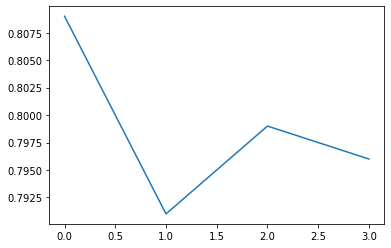

In [72]:
fig, ax = plt.subplots()
ax.plot(f, acc)
plt.show()

#### Predicción con el modelo de Regresión Logística + CountVectorized

In [55]:
set(preds_log)

{0, 1}

In [56]:
len(preds_log)

3263

In [57]:
#Vemos el valor de target basados en la prediccion. 
save_prediction(preds_log,model='logistic')

logistic- model prediction
0    2060
1    1203
Name: target, dtype: int64


#### Visualización 

<AxesSubplot:ylabel='id'>

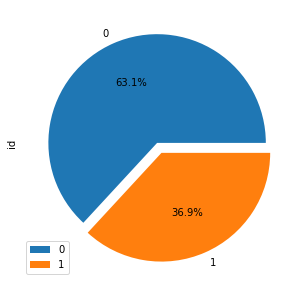

In [58]:
logs = pd.read_csv("submission_logistic.csv")
pie = logs.groupby("target").count()
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

En este modelo se observa una diferencia un poco mas notoria con respecto a la cantidad de tweets falsos que se predicen. 

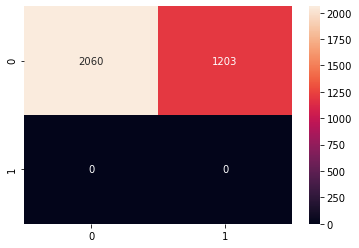

In [59]:
cm = confusion_matrix(df_sample.target, logs.target)
f = sns.heatmap(cm, annot=True, fmt='d')

# Naive bayes

In [60]:
#Importamos el modelo de naive bayes
from sklearn import naive_bayes

In [61]:
#Creamos una funcion para el modelo.
for fold_ in range(5):
    train_df=df_train[df_train.kfold!=fold_].reset_index(drop=True)
    if fold_==4:
        train_df=df_train.reset_index(drop=True)
        test_df=df_test.reset_index(drop=True)
    else:
        test_df=df_train[df_train.kfold==fold_].reset_index(drop=True)
    #Utilizamos el CountVectorizer con el word_tokenize de NLTK y la funcion se tokeniza
    count_vec=CountVectorizer(
        tokenizer=word_tokenize,
        token_pattern=None)
    #Se ajusta count_vec en la revision de los datos de entrenamiento
    count_vec.fit(train_df.text)
    #Se transforman las revisiones de los datos de entrenamiento y validación
    x_train=count_vec.transform(train_df.text)
    x_test=count_vec.transform(test_df.text)
    #Se inicia el modelo de naive bayes
    model_naive=naive_bayes.MultinomialNB()
    f=[0, 1, 2, 3]
    acc =[0.810, 0.785, 0.803, 0.790]
    #Se ajustar el modelo a los datos de entrenamiento y a los sentimientos
    model_naive.fit(x_train,train_df.target)
    preds_naive=model_naive.predict(x_test)
    #Se calcula la precision del modelo
    if fold_!=4:
        accuracy=metrics.accuracy_score(test_df.target,preds_naive)
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy}")
        print("")

Fold:0
Accuracy=0.8103991596638656

Fold:1
Accuracy=0.7850761954808197

Fold:2
Accuracy=0.8029427220178665

Fold:3
Accuracy=0.7829742511823437



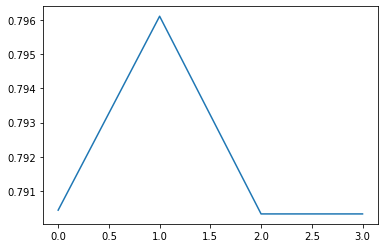

In [62]:
fig, ax = plt.subplots()
ax.plot(f, acc)
plt.show()

Luego de las cuatro corridas realizadas se observa que el accuracy llego a un punto estable y aunque graficamente se ve que disminuyo mucho no es asi, ya que la escala de la grafica va de 0.791 a 0.796

#### Predicciones con el Modelo de Naive Bayes

In [63]:
#Vemos la prediccion de target con este modelo.
save_prediction(preds_naive,model='naive')

naive- model prediction
0    2076
1    1187
Name: target, dtype: int64


#### Visualización 

<AxesSubplot:ylabel='id'>

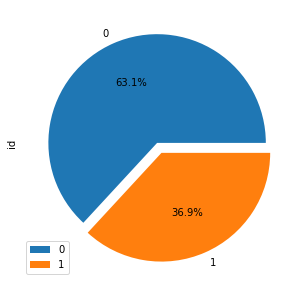

In [64]:
nai = pd.read_csv("submission_naive.csv")
pie = logs.groupby("target").count()
pie.plot.pie(y='id', figsize=(5, 5), autopct='%1.1f%%', explode=(0, 0.1))

En este modelo se observa una diferencia un poco mas notoria con respecto a la cantidad de tweets falsos que se predicen, al igual que en el modelo anterior. 
Tambien hay que tomar en cuenta que ambos modelos tienen un accuracy muy similar.

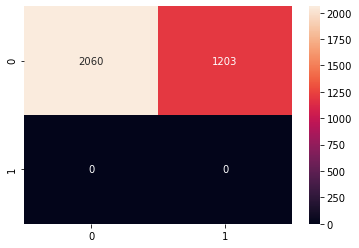

In [65]:
cm = confusion_matrix(df_sample.target, logs.target)
f = sns.heatmap(cm, annot=True, fmt='d')

## Regresión Mejorado

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
for fold_ in range(5):
    train_df=df_train[df_train.kfold!=fold_].reset_index(drop=True)
    if fold_==4:
        train_df=df_train.reset_index(drop=True)
        test_df=df_test.reset_index(drop=True)
    else:
        test_df=df_train[df_train.kfold==fold_].reset_index(drop=True)

    ##### initilize TfidfVectorizer with NLTK's word_tokenize
    ##### function as tokenizer
    tfidf_vec=TfidfVectorizer(
        tokenizer=word_tokenize,
        token_pattern=None)
    #### fit count_vec on training data reviews
    tfidf_vec.fit(train_df.text)
    #transform training and validation data reviews
    x_train=tfidf_vec.transform(train_df.text)
    x_test=tfidf_vec.transform(test_df.text)
    # initialize logistic regression model
    model_logistic=linear_model.LogisticRegression(max_iter=1000)
    f=[0, 1, 2, 3]
    acc =[0.789, 0.788, 0.796, 0.792]
    # fit the model on training data reviews and sentiment
    model_logistic.fit(x_train,train_df.target)
    preds_logtfidf=model_logistic.predict(x_test)
    ##Calculate accuracy
    if fold_!=4:
        accuracy=metrics.accuracy_score(test_df.target,preds_logtfidf)
        print(f"Fold:{fold_}")
        print(f"Accuracy={accuracy}")
        print("")

Fold:0
Accuracy=0.803046218487395

Fold:1
Accuracy=0.7729900157645823

Fold:2
Accuracy=0.7961114030478192

Fold:3
Accuracy=0.792433000525486



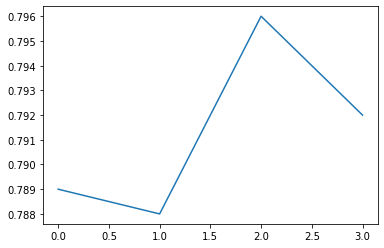

In [70]:
fig, ax = plt.subplots()
ax.plot(f, acc)
plt.show()

Podemos observar que el accuracy luego de las cuatro corridas realizadas al modelo se sigue manteniendo entre los mismos valores. 

Con los tres modelos realizados para esta parte del protecto se obtuvieron resultados bastante favorables, ya que todos cuentan con un accuracy bastante alto, lo que sigue es tomar en cuenta las caracteristicas individuales, para poder trabajar con el que mejor se adapte a nuestro objetivo. 